In [1]:
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm
from datetime import timedelta

In [2]:
def lerp(start, end, t):
	r = start[0] + (end[0] - start[0]) * t
	g = start[1] + (end[1] - start[1]) * t
	b = start[2] + (end[2] - start[2]) * t
	a = start[3] + (end[3] - start[3]) * t
	return (r / 255.0, g / 255.0, b / 255.0, a)

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [3]:
# Max 4 172 790
hex_list = ['#85ff00', '#fff100', '#ffaa04', '#ff0000', '#dc00ff', '#6700d4', '#1200db', '#0a014a']
scales = [0, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
colors = [(0x85, 0xff, 0x00, 1.0), (0xff, 0xf1, 0x00, 1.0), (0xff, 0xaa, 0x04, 1.0), (0xff, 0x00, 0x00, 1.0), (0xdc, 0x00, 0xff, 1.0), (0x67, 0x00, 0xd4, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x12, 0x00, 0xdb, 1.0), (0x0a, 0x01, 0x4a, 1.0), ]

In [4]:
df = pd.read_csv('exposed_by_vendor.csv')
vendor_names = list(set(df.vendor.unique()) - set(["?"]))

dates = sorted(list(df.date.unique()))

done = 0
output = {}
first_appearance = {}
for vendor in vendor_names:
	c = []
	for d in range(len(dates)):
		#print(dates[d], infection in list(df[(df.date == dates[d])]['infection']))
		if not vendor in list(df[(df.date == dates[d])]['vendor']) or df[(df.date == dates[d]) & (df.vendor == vendor)]['count'].iloc[0] == 0:
			c += [(0, 0, 0, 0)]
		else:
			first_appearance[vendor] = dates[d]
			v = df[(df.date == dates[d]) & (df.vendor == vendor)]['count'].iloc[0]
			idx = -1
			for s in range(len(scales) - 1):
				if scales[s] < v and v <= scales[s+1]:
					idx = s
			if idx == -1:
				c += [lerp(colors[-1], colors[-1], 0.5)]
			else:
				c += [lerp(colors[idx], colors[idx+1], (v - scales[idx])/(scales[idx + 1] - scales[idx]))]
	done += 1
	print(f'{str(done).zfill(len(str(len(vendor_names))))}/{len(vendor_names)}: {vendor}')
	output[vendor] = c


001/139: LILIN
002/139: TerraMaster
003/139: Dell
004/139: Cisco
005/139: Nokia
006/139: Sercomm
007/139: Polycom
008/139: Linksys
009/139: Atlassian
010/139: Canon
011/139: Mersive
012/139: Mitel
013/139: F5
014/139: Broadcom
015/139: ELAN
016/139: Lenovo
017/139: Vanderbilt Industries
018/139: FiberHome
019/139: ZTE
020/139: Lantronix
021/139: Hitron
022/139: ZoneHub
023/139: Allworx
024/139: NETGEAR
025/139: Ericsson-LG
026/139: Wilibox
027/139: Microhard Systems
028/139: Pakedge
029/139: HAProxy
030/139: TP-Link
031/139: Bouygues Telecom
032/139: Wildix
033/139: Audiocodes
034/139: OpenWrt
035/139: CWP
036/139: KAONMEDIA
037/139: Huawei
038/139: Comtrend
039/139: LaCie
040/139: Ubiquiti
041/139: TRASSIR
042/139: Allegro Software
043/139: Western Digital
044/139: Orange
045/139: Hikvision
046/139: AudioCodes
047/139: iRobot
048/139: Barracuda Networks
049/139: Truen
050/139: Philips
051/139: Honeywell
052/139: Digi International
053/139: Tridium
054/139: Siemens
055/139: Yealink
056

KeyboardInterrupt: 

In [ ]:
from json import dumps
jsonified = dumps(output)
with open('./exposed-vendor.json', 'w') as f:
    f.write(jsonified)
    f.close()

In [ ]:
# Sort infection names initial date (color tuple not 0 0 0 0 ) then alphabetical
appearance = {}
for vendor in vendor_names:
    for c in range(len(output[vendor])):
        if output[vendor][c][0] != 0 or output[vendor][c][1] != 0 or output[vendor][c][2] != 0 or output[vendor][c][3] != 0:
            appearance[vendor] = c
            break

appearance_inv = {i: [] for i in range(len(dates))}

for v in sorted(list(appearance.items()), key=lambda x: x[1]):
    appearance_inv[v[1]] += [v[0]]

for i in range(len(dates)):
    if len(appearance_inv[i]) == 0:
        del(appearance_inv[i])
    else:
        appearance_inv[i] = sorted(appearance_inv[i])

vendor_names_sorted = [x for xs in [v for k, v in appearance_inv.items()] for x in xs][::-1]

In [ ]:
norm=LogNorm(vmin=1, vmax=9999999)
cmappable = ScalarMappable(norm=norm, cmap=get_continuous_cmap(hex_list=hex_list))

In [ ]:
dates = sorted(list(df.date.unique()))
m_dates = mdates.num2date(mdates.datestr2num(dates))
m_dates[-1]

datetime.datetime(2022, 5, 4, 0, 0, tzinfo=datetime.timezone.utc)

001/139: AVTECH
002/139: Schmid
003/139: Realtron
004/139: Polycom
005/139: Gargoyle
006/139: CIG
007/139: Vivint
008/139: Linksys
009/139: ELKO EP
010/139: ELAN
011/139: Xfinity
012/139: Verizon
013/139: CommuniGate
014/139: SMA
015/139: HiSilicon
016/139: NETWAVE
017/139: Hitron
018/139: iKuai
019/139: iCatch
020/139: TRASSIR
021/139: KAONMEDIA
022/139: Hughes
023/139: Apple
024/139: Mitel
025/139: The VyOS Project
026/139: SmartRG
027/139: CWP
028/139: HAProxy
029/139: Synacor
030/139: Citrix
031/139: TerraMaster
032/139: Wildix
033/139: Unified Office
034/139: Intelbras
035/139: Bouygues Telecom
036/139: AMI
037/139: F5
038/139: AudioCodes
039/139: Allegro Software
040/139: Cambium Networks
041/139: Rockwell Automation
042/139: LILIN
043/139: Netia
044/139: Compal
045/139: Nasuni
046/139: Lenovo
047/139: QLC Chain
048/139: Lantronix
049/139: Aruba Networks
050/139: LANCOM
051/139: GreenWave
052/139: Barracuda Networks
053/139: Moxa
054/139: Honeywell
055/139: Heatmiser
056/139: Mik

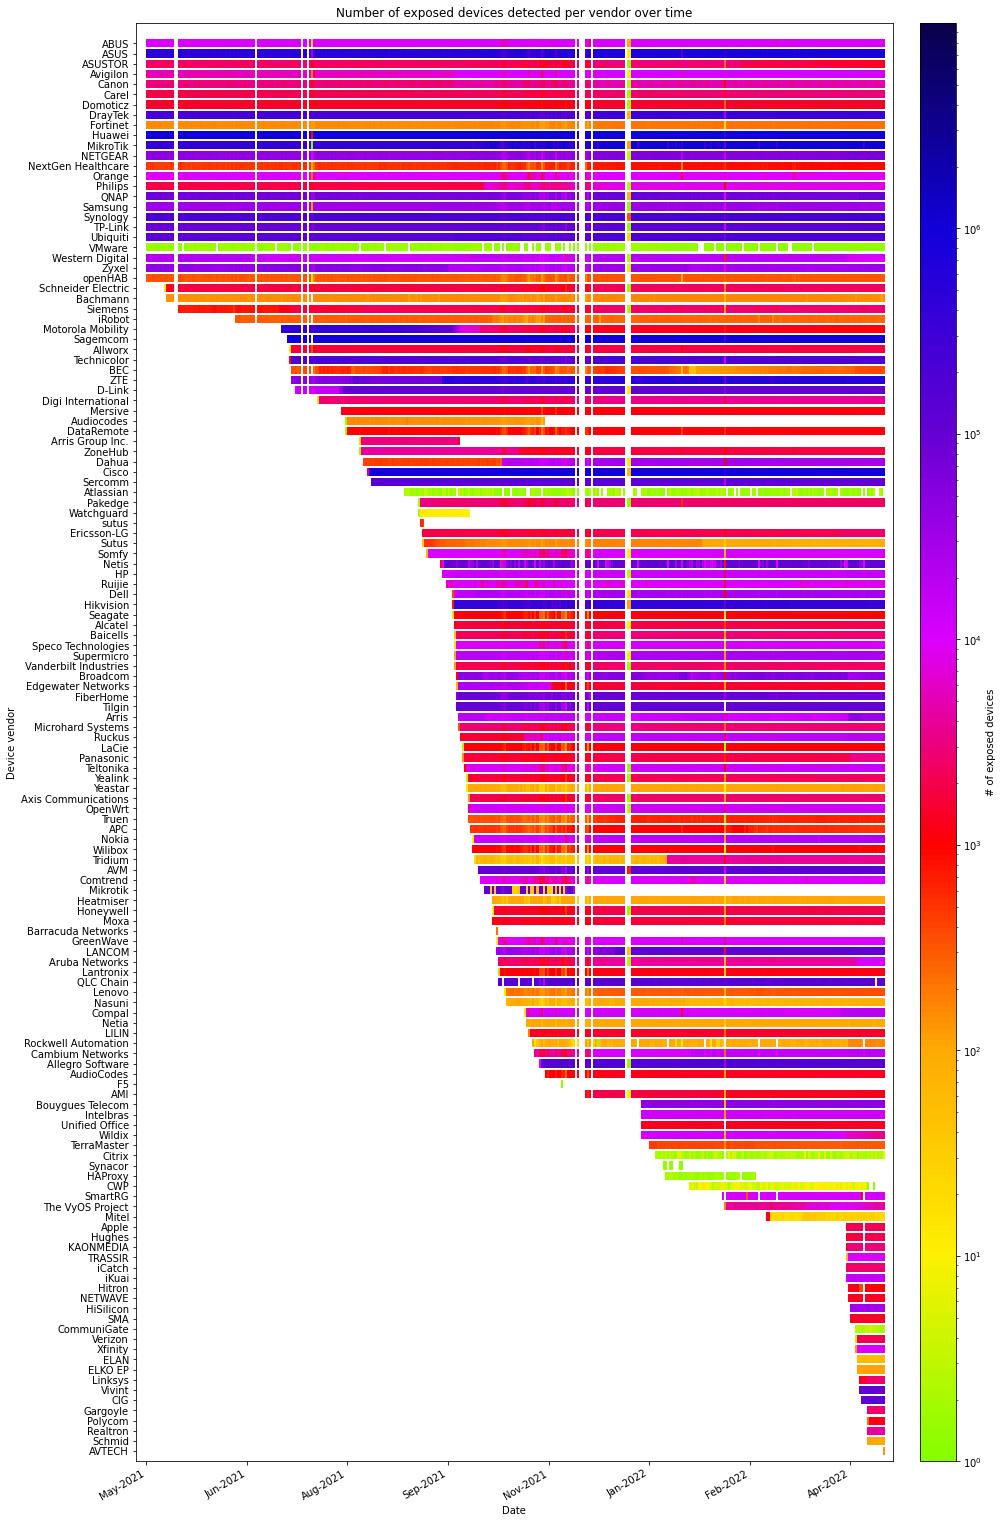

In [ ]:

plt.rcParams["figure.figsize"] = (16.54, 29.38)

fig, ax = plt.subplots(figsize=(16.54, 29.38))
y = 0
done = 0

for vendor in vendor_names_sorted:
	for c in range(len(output[vendor])):
		ax.barh(y, 1, left= m_dates[c], height=0.8, align='center', color=output[vendor][c])
	y += 1
	done += 1
	print(f'{str(done).zfill(len(str(len(vendor_names))))}/{len(vendor_names)}: {vendor}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
ax.axis('tight')
ax.set_xlim([m_dates[0] - timedelta(days=5), m_dates[-1] + timedelta(days=5)])
ax.set_ylim([-1, len(vendor_names) + 1])
ax.set_yticks(np.arange(len(vendor_names)))
ax.set_yticklabels(vendor_names_sorted)

ax.set_xlabel('Date')
ax.set_ylabel('Device vendor')

fig.autofmt_xdate()

cb =fig.colorbar(cmappable, aspect=40, pad=0.03)
cb.ax.set_ylabel('# of exposed devices')

ax.set_title("Number of exposed devices detected per vendor over time")

plt.savefig('../images/exposed-byvendor-better.png', facecolor='white', transparent=False, bbox_inches='tight', pad_inches=.2, dpi=300)
plt.show()